In [1]:
import logging

logging.basicConfig(
    level="INFO", format="%(asctime)s %(message)s", datefmt="%d-%b-%y %H:%M:%S"
)


In [2]:
from src.load_data import load_data
from src.parameters import SAMPLING_FREQUENCY

(position_info, spikes, multiunit_firing_rate, multiunit_HSE_times) = load_data(
    position_file_name="../Raw-Data/position4Xulu_1.csv",
    spike_file_name="../Raw-Data/df4Xulu_1.csv")

# cut out first 20 s because animal is being placed on track
start_ind = int(20.0 * SAMPLING_FREQUENCY)
position_info = position_info.iloc[start_ind:]
spikes = spikes.iloc[start_ind:]
multiunit_firing_rate = multiunit_firing_rate.iloc[start_ind:]


03-Mar-23 12:05:38 Note: detected 96 virtual cores but NumExpr set to maximum of 64, check "NUMEXPR_MAX_THREADS" environment variable.
03-Mar-23 12:05:38 Note: NumExpr detected 96 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
03-Mar-23 12:05:38 NumExpr defaulting to 8 threads.


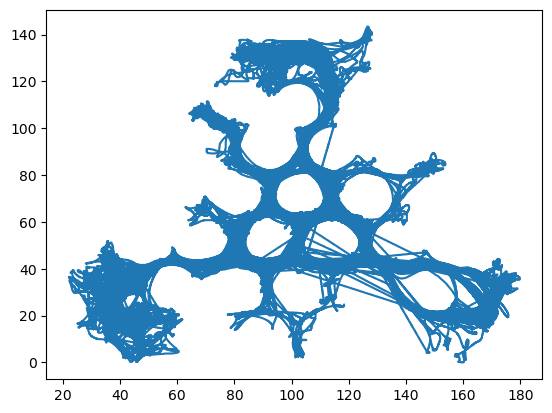

In [3]:
import matplotlib.pyplot as plt

plt.plot(position_info.x, position_info.y)

<Axes: >

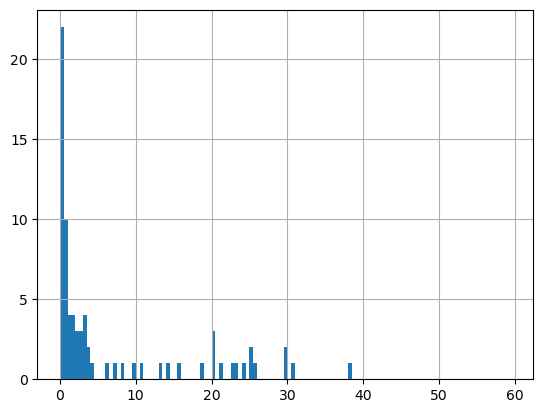

In [4]:
import numpy as np


(spikes.mean() * SAMPLING_FREQUENCY).hist(bins=np.arange(0, 60, 0.5))

In [5]:
from replay_trajectory_classification import (
    SortedSpikesClassifier,
    Environment,
    RandomWalk,
    Uniform,
)


environment = Environment(place_bin_size=2.0)
continuous_transition_types = [
    [RandomWalk(movement_var=12.0), Uniform()],
    [Uniform(), Uniform()],
]


classifier = SortedSpikesClassifier(
    environments=environment,
    continuous_transition_types=continuous_transition_types,
    sorted_spikes_algorithm="spiking_likelihood_kde_gpu",
    sorted_spikes_algorithm_params={
        "position_std": 6.0,
        "use_diffusion": False,
        "block_size": int(2**12),
    },
)

classifier


/home/edeno/miniconda3/envs/tk_decoding/lib/python3.10/site-packages/replay_trajectory_classification/likelihoods/multiunit_likelihood.py:8: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


SortedSpikesClassifier(continuous_transition_types=[[RandomWalk(environment_name='',
                                                                movement_var=12.0,
                                                                movement_mean=0.0,
                                                                use_diffusion=False),
                                                     Uniform(environment_name='',
                                                             environment2_name=None)],
                                                    [Uniform(environment_name='',
                                                             environment2_name=None),
                                                     Uniform(environment_name='',
                                                             environment2_name=None)]],
                       discrete_transition_type=DiagonalDiscrete(diagona...
                       infer_track_interior=True,
                       initial_conditions_type=UniformInitialConditions(),
                       observation_models=(ObservationModel(environment_name='',
                                                            encoding_group=0),
                                           ObservationModel(environment_name='',
                                                            encoding_group=0)),
                       sorted_spikes_algorithm='spiking_likelihood_kde_gpu',
                       sorted_spikes_algorithm_params={'block_size': 4096,
                                                       'position_std': 6.0,
                                                       'use_diffusion': False})

In [6]:
import cupy as cp
import xarray as xr


state_names = ["continuous", "fragmented"]

GPU_ID = 8

n_time = len(spikes)
n_segments = 2

results = []

# use context manager to specify which GPU (device)
with cp.cuda.Device(GPU_ID):
    # Fit the place fields
    classifier.fit(
        position=position_info[["x", "y"]],
        spikes=spikes,
    )

    for ind in range(n_segments):
        time_slice = slice(ind * n_time // n_segments, (ind + 1) * n_time // n_segments)
        results.append(
            classifier.predict(
                spikes.iloc[time_slice],
                time=spikes.iloc[time_slice].index.to_numpy(),
                state_names=state_names,
                use_gpu=True,
            )
        )
    logging.info("Done!")

results = xr.concat(results, dim="time")
results


03-Mar-23 12:06:23 Fitting initial conditions...
03-Mar-23 12:06:23 Fitting continuous state transition...
/home/edeno/miniconda3/envs/tk_decoding/lib/python3.10/site-packages/replay_trajectory_classification/continuous_state_transitions.py:23: RuntimeWarning: invalid value encountered in divide
  x /= x.sum(axis=1, keepdims=True)
03-Mar-23 12:06:28 Fitting discrete state transition
03-Mar-23 12:06:28 Fitting place fields...


  0%|          | 0/77 [00:00<?, ?it/s]

/home/edeno/miniconda3/envs/tk_decoding/lib/python3.10/site-packages/replay_trajectory_classification/likelihoods/spiking_likelihood_kde_gpu.py:115: RuntimeWarning: divide by zero encountered in log
  np.log(mean_rate) + np.log(marginal_density) - np.log(occupancy)
/home/edeno/miniconda3/envs/tk_decoding/lib/python3.10/site-packages/replay_trajectory_classification/likelihoods/spiking_likelihood_kde_gpu.py:115: RuntimeWarning: invalid value encountered in subtract
  np.log(mean_rate) + np.log(marginal_density) - np.log(occupancy)
03-Mar-23 12:09:05 Estimating likelihood...


  0%|          | 0/77 [00:00<?, ?it/s]

03-Mar-23 12:12:18 Estimating causal posterior...
03-Mar-23 12:18:54 Estimating acausal posterior...
03-Mar-23 12:44:43 Estimating likelihood...


  0%|          | 0/77 [00:00<?, ?it/s]

03-Mar-23 12:47:48 Estimating causal posterior...
03-Mar-23 12:54:17 Estimating acausal posterior...
03-Mar-23 13:20:13 Done!


<xarray.Dataset>
Dimensions:            (time: 1780831, state: 2, x_position: 81, y_position: 74)
Coordinates:
  * time               (time) float64 21.51 21.52 21.52 ... 7.145e+03 7.145e+03
  * x_position         (x_position) float64 21.1 23.1 25.1 ... 176.8 178.8 180.8
  * y_position         (y_position) float64 -0.9963 0.9963 2.989 ... 142.5 144.5
  * state              (state) <U10 'continuous' 'fragmented'
Data variables:
    likelihood         (time, state, x_position, y_position) float32 nan ... nan
    causal_posterior   (time, state, x_position, y_position) float32 nan ... nan
    acausal_posterior  (time, state, x_position, y_position) float32 nan ... nan
Attributes:
    data_log_likelihood:  -692390.25

In [7]:
results.drop(["likelihood", "causal_posterior"]).to_netcdf(
    "../Processed-Data/results_1.nc"
)


In [8]:
classifier.save_model("../Processed-Data/classifier_1.pkl")


In [15]:
from src.plot_data import create_interactive_2D_decoding_figurl

n_time = len(spikes)
n_segments = 2

for ind in range(n_segments):
    time_slice = slice(ind * n_time // n_segments,
                       (ind + 1) * n_time // n_segments)


    view = create_interactive_2D_decoding_figurl(
        position_info.iloc[time_slice],
        multiunit_firing_rate.iloc[time_slice],
        results.isel(time=time_slice),
        bin_size=environment.place_bin_size,
        position_name=["x", "y"],
        speed_name="speed",
        posterior_type="acausal_posterior",
        view_height=800,
    )

    print(view.url(label=f"Barrier 2D Decode_{ind}"))


Computing sha1 of /stelmo/nwb/.kachery-cloud/tmp_cs4ANhGl/file.dat
https://figurl.org/f?v=gs://figurl/spikesortingview-10&d=sha1://73ea2f617d53751b2c4d0b80df5614c4411bdcba&label=Barrier%202D%20Decode_0&zone=franklab.default
Computing sha1 of /stelmo/nwb/.kachery-cloud/tmp_VHZgwKq8/file.dat
https://figurl.org/f?v=gs://figurl/spikesortingview-10&d=sha1://3ac8a3e3f26b6241b178c43173590ab20e39f38a&label=Barrier%202D%20Decode_1&zone=franklab.default
